In [97]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
import random
from gensim.utils import simple_preprocess
from multiprocessing import Pool
plt.rcParams['figure.figsize'] = [10, 6]

# Traer las preguntas similares

In [3]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1", port="63333", database="stack_overflow")

In [12]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select count(*)
        FROM posts_19 q
        JOIN posts_19_tags pt on pt.post_id=q.id
        JOIN tags t on pt.tag_id=t.id
        JOIN posts_19 q_aa ON q_aa.id = q.accepted_answer_id
        JOIN posts_19 sa ON sa.owner_user_id=q_aa.owner_user_id
        WHERE q.body_text is not null
        and sa.parent_id != q.id 
        and q.post_type_id=1 
        and q.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        and q_aa.post_type_id=2 
        and sa.post_type_id=2""")
        posts = cursor.fetchall()
posts

[(466969810,)]

In [113]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q.id, sa.parent_id, q_aa.owner_user_id, q.body_text, q.title, sq.body_text, sq.title
        FROM posts_19 q
        JOIN posts_19_tags pt on pt.post_id=q.id
        JOIN tags t on pt.tag_id=t.id
        JOIN posts_19 q_aa ON q_aa.id = q.accepted_answer_id
        JOIN posts_19 sa ON sa.owner_user_id=q_aa.owner_user_id
        JOIN posts_19 sq ON sq.id=sa.parent_id
        WHERE q.body_text is not null
        and sa.parent_id != q.id 
        and q.post_type_id=1 
        and q.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        and q_aa.post_type_id=2 
        and sa.post_type_id=2
        limit 100000""")
        posts = pd.DataFrame(cursor.fetchall(), columns=["q_id", "sq_id", "user_id", "q_text", "q_title", "sq_text", "sq_title"])

In [116]:
posts.head()

,q_id,sq_id,user_id,q_text,q_title,sq_text,sq_title
0,466345,331367,41165,How do I convert the following string to a dat...,"Convert string ""Jun 1 2005 1:33PM"" into datetime",Say I have 2 tables: Customers and Orders. A C...,SQL Statement Help - Select latest Order for e...
1,466611,4869770,17017,When using Python's super() to do method chain...,Why do I have to specify my own class when usi...,Why is Python assignment a statement rather th...,Why does Python assignment not return a value?
2,466611,5853183,17017,When using Python's super() to do method chain...,Why do I have to specify my own class when usi...,Can I specify the name I want for the many to ...,Django admin many to many table name
3,467920,354883,15154,I'm speaking of this module:\nhttp://docs.pyth...,In what situation should the built-in 'operato...,The canonical way to return multiple values in...,Alternatives for returning multiple values fro...
4,467920,48905129,15154,I'm speaking of this module:\nhttp://docs.pyth...,In what situation should the built-in 'operato...,"In PowerShell (5.1.14393.1944), when I have a ...",ForEach-Object loop running when variable valu...


### Calcular distancias

In [117]:

model = Doc2Vec.load("python.doc")

In [119]:
def get_vector(body, title):
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    return model.infer_vector(simple_preprocess(post_text))

def calculate_distance(similar_questions):
    q_body, q_title, sq_body, sq_title = similar_questions
    return np.linalg.norm(get_vector(q_body, q_title)-get_vector(sq_body, sq_title))

In [120]:
with Pool(8) as p:
    distances = p.map(calculate_distance,  posts[["q_text", "q_title", "sq_text", "sq_title"]].values.tolist())

In [121]:
distances = np.array(distances)
distances.mean(), distances.std()

(12.447124, 2.2806447)

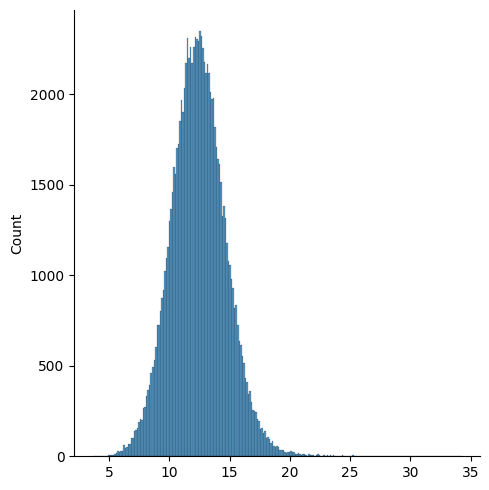

In [122]:
sns.displot(distances)

In [123]:
len(distances)

100000

### Preguntas al azar

In [124]:
sample_size = 100000
samples = random.sample(range(len(model.dv)), sample_size*2)

In [125]:
random_distances = []
for q_v, sq_v in zip(samples[:sample_size], samples[sample_size:]):
    random_distances.append(np.linalg.norm(q_v- sq_v))

In [126]:
random_distances = np.array(random_distances)
random_distances.mean(), random_distances.std()

(299076.99576, 210837.81289256737)

In [130]:
random_distances[:10]

array([536149.,  87731.,  57596.,  20649., 524146., 619645., 147527.,
       154989., 514818., 400050.])

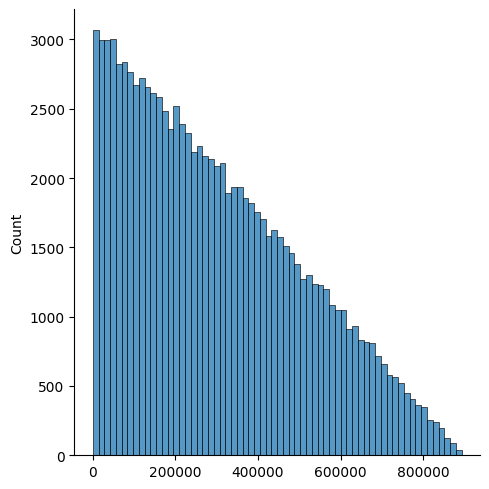

In [127]:
sns.displot(random_distances)

In [128]:
len(random_distances)

100000

### Answers per user with accepted answers

In [38]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""
                select ans.owner_user_id, count(*)
                from posts_19 ans
                join posts_19 p on ans.parent_id = p.id
                JOIN posts_19_tags pt on pt.post_id=p.id
                JOIN tags t on pt.tag_id=t.id
                where ans.post_type_id=2
                and p.creation_date < '2022-01-01'
                and t.tag_name = 'python'
                and ans.owner_user_id in (
                        select distinct(a.owner_user_id)
                        from posts_19 a
                        join posts_19 p on a.id = p.accepted_answer_id
                        JOIN posts_19_tags pt on pt.post_id=p.id
                        JOIN tags t on pt.tag_id=t.id
                        where a.post_type_id=2
                        and p.post_type_id=1
                        and p.creation_date < '2022-01-01'
                        and t.tag_name = 'python'
                )
                group by ans.owner_user_id""")
        ans_per_user = pd.DataFrame(cursor.fetchall(), columns=["u_id", "total_answers"])
ans_per_user.head()

,u_id,total_answers
0,57,2
1,86,3
2,95,1
3,99,3
4,115,2


In [8]:
ans_per_user["total_answers"].describe()

count    80118.000000
mean        10.736039
std         75.700940
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      11681.000000
Name: total_answers, dtype: float64

In [129]:
ans_per_user["total_answers"].median()

2.0

In [23]:
ans_per_user["total_answers"].sort_values(ascending=False)[:10]

16244    11681
38374     5163
21962     4811
47722     4088
27921     3249
11241     3237
32490     3070
893       2908
7468      2888
6260      2540
Name: total_answers, dtype: int64

<Axes: xlabel='total_answers', ylabel='Count'>

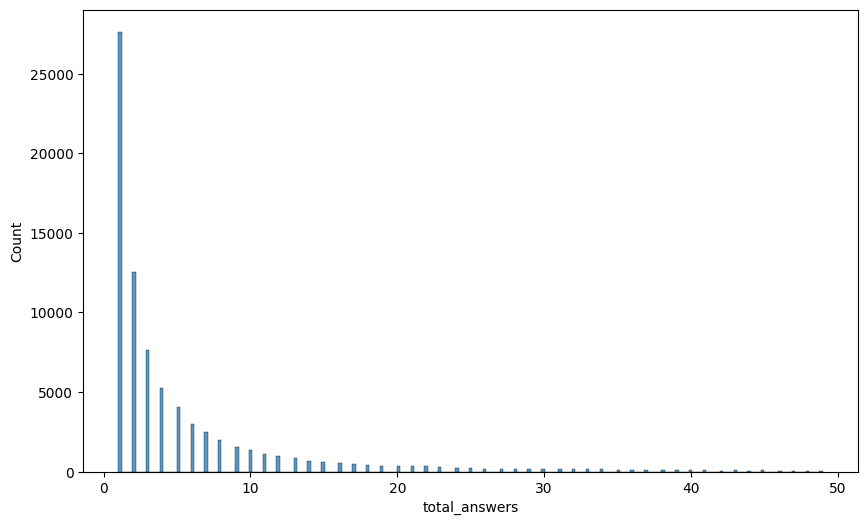

In [37]:
sns.histplot(ans_per_user[ans_per_user["total_answers"]<50]["total_answers"])

### How many questions with accepted answer are there?

In [14]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""
                select count(*)
                from posts_19 p
                JOIN posts_19_tags pt on pt.post_id=p.id
                JOIN tags t on pt.tag_id=t.id
                where p.post_type_id=1
                and p.creation_date < '2022-01-01'
                and t.tag_name = 'python'
                and p.accepted_answer_id is not null""")
        total_aa = cursor.fetchall()
total_aa

[(446528,)]